## PINN Helmholtz solver for a portion of the Munk velocity model  

Part of profile "Munk profile, coherent" from Munk_arr.env  
>*depth,m|ssp,m/s*   
 zs-200.0 | 1541.76   
 zs-100.0 | 1545.14   
 zs+100.0 | 1548.52    

In [1]:
# conda install tensorflow-gpu==2.1.0 matplotlib
# pip install sciann
# sciann version: 0.6.3.1
import pathlib
import numpy as np
import time
import sciann as sn
from sciann_datagenerator import DataGeneratorXYT
from sciann.utils.math import diff
import tensorflow.keras.callbacks as callbacks
from scipy.special import hankel1
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import tensorflow as tf

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

### Model specifications  
Plot the velocity model with the source location

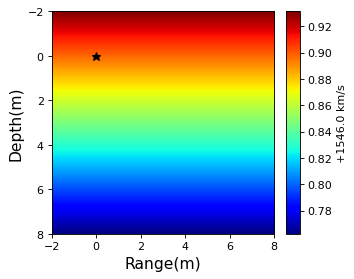

In [3]:
# boundary [-2 : 8] x [ -2 : 8]
start = -2
end = 8

# Point-source loaction
sz = 0.0; sr = 0.0; 
amp = 1

# Number of training points
num_tr_pts = 10000

# ssp
z_old = [-100, 100]
z_new = np.linspace(-100, 100, num=10001, endpoint=True)
c_old = [1545.14, 1548.52]
f1 = interp1d(z_old, c_old)
ssp = f1(z_new).T
ssp_1 = ssp[z_new==start]
ssp_2 = ssp[z_new==end]
ssp_s = ssp[z_new==sz]

deltar = 0.02; deltaz = 0.02;
z = np.arange(start, end+deltaz, deltaz)
r = np.arange(start, end+deltar, deltar)
Z,R = np.meshgrid(z,r,indexing='ij')
vergrad = (ssp_2 - ssp_1) / (end - start)

velmodel = ( ssp_1 + vergrad * ( Z - sz ) ) - 1546

# plot velmodel
plt.style.use('default')
plt.figure(figsize=(4,4), dpi=80)
ax = plt.gca()
im = ax.imshow(velmodel, extent=[start,end,start,end], aspect=1, cmap="jet")
ax.plot(sr, sz, 'k*', markersize=8)
ax.invert_yaxis()
plt.xlabel('Range(m)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth(m)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(2.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(2.0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('+1546.0 km/s',size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

### Creating grid  
calculating refrence traveltimes, and prepare list of grid points for training (X_star)

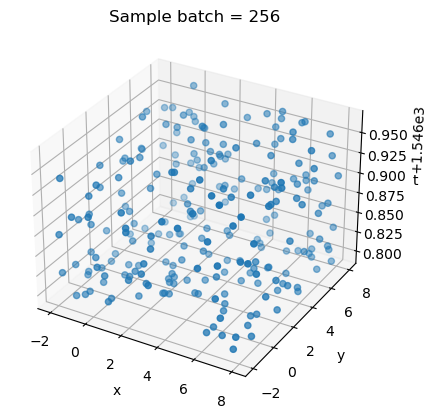

In [4]:
dg = DataGeneratorXYT(
    X=[start, end],
    Y=[start, end],
    T=[ssp_1, ssp_2],
#     targets=["all"],
    num_sample=num_tr_pts,
)
dg.plot_sample_batch(batch_size=256)
xx = np.squeeze(dg.input_data[0])
yy = np.squeeze(dg.input_data[1])
X_starf = dg.input_data
input_data, target_data = dg.get_data()
rr = np.sqrt((xx-sr)**2 + (yy-sz)**2)

# Green(x,y) = Hankel_0^1(k * r)
freq = 50.0
Pi = 3.141592653

omega = 2 * Pi * freq
m0 = 1 / ssp_s    # ssp in source's depth
m1 = 1 / input_data[2]
k0 = omega * m0 # for Green's background pressure field
k1 = omega * m1 # random sampled ssp

# complex valued part is phase shifted by 90°

# exact pressure field
u0_real = np.real(amp * hankel1(0, k1*rr))
u0_imag = np.imag(amp * hankel1(0, k1*rr))
# background field
G0_real = np.real(amp * hankel1(0, k0*rr))
G0_imag = np.imag(amp * hankel1(0, k0*rr))

# Scatter pressure field
dp_real = u0_real - G0_real
dp_imag = u0_imag - G0_imag

### Preparing the Sciann model object with variable and Functional

In [5]:
layers = 10*[20]

# k0_data = omega * m0 * np.ones(r_data.shape)
# k1_data = omega * m1 * np.ones(r_data.shape)

# Variable and Fields
rp = sn.Variable("rp", dtype='float64')
zp = sn.Variable("zp", dtype='float64')
cp = sn.Variable("cp", dtype='float64')
G_real = sn.Variable("G_real", dtype='float64')
G_imag = sn.Variable("G_imag", dtype='float64')

p_real = sn.Functional("p_real", [zp, rp], layers, "l-atan")
p_imag = sn.Functional("p_imag", [zp, rp], layers, "l-atan")

k0 = omega * m0
k1 = omega / cp
# pde ($\Delta p + k^2 \cdot p = 0$) split into real- and complex-valued part
laplace_Re_dp = diff(p_real, rp, order=2) + diff(p_real, zp, order=2)
laplace_Im_dp = diff(p_imag, rp, order=2) + diff(p_imag, zp, order=2)

L1 = laplace_Re_dp+k1**2 * p_real + (k1**2 - k0**2)*G_real
L2 = laplace_Im_dp+k1**2 * p_imag + (k1**2 - k0**2)*G_imag
c1 = sn.Data(p_real)
c2 = sn.Data(p_imag)

# model and input
input = [rp, zp, cp, G_real, G_imag]
input_value = X_starf + [G0_real, G0_imag]
target = [sn.PDE(L1), sn.PDE(L2), c1, c2]
target_value = ['zeros', 'zeros', dp_real, dp_imag]
model = sn.SciModel(
    input,
    target)
#     optimizer='scipy-l-BFGS-B')
#     load_weights_from='model/2D1_dp_inv_WEIGHT.hdf5')
#         optimizer='scipy-l-BFGS-B')

# callbacks
current_path = os.path.abspath('')
checkpoint_filepath = str(os.path.join(current_path,'callbacks/N2Green/N2Green_dp.ckpt'))
save_path1 = str(os.path.join(current_path,'model/2D1_dp_INV_WEIGHT.hdf5'))
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True
)

t = time.time()
history = model.train(
    input_value,
    target_value,
    epochs=1500,
    batch_size=400,
    adaptive_weights={"method": "NTK", "freq": 100},
    # callbacks=[model_checkpoint_callback],
    shuffle=True,
    learning_rate=0.005,
    reduce_lr_after=100,
    stop_loss_value=1e-8
)
t = time.time() - t
#
model.save_weights(save_path1)


Total samples: 11250 
Batch size: 400 
Total batches: 29 

577.4765362739563

+ adaptive_weights at epoch 1: [0.7336458428310962, 1.1374665723764772, 0.878642951154934, 1.2502446336374926]
Epoch 1/1500
29/29 [==============================] - 14s 468ms/step - loss: 0.0599 - add_4_loss: 0.0172 - add_6_loss: 0.0073 - p_real_loss: 0.0194 - p_imag_loss: 0.0178
Epoch 2/1500
29/29 [==============================] - 2s 63ms/step - loss: 0.0011 - add_4_loss: 2.5815e-04 - add_6_loss: 1.8383e-04 - p_real_loss: 5.0709e-04 - p_imag_loss: 1.6682e-04
Epoch 3/1500
29/29 [==============================] - 2s 63ms/step - loss: 1.3064e-04 - add_4_loss: 4.2502e-05 - add_6_loss: 4.3190e-05 - p_real_loss: 3.7444e-05 - p_imag_loss: 1.4017e-05
Epoch 4/1500
29/29 [==============================] - 2s 62ms/step - loss: 5.9270e-05 - add_4_loss: 2.0557e-05 - add_6_loss: 2.7038e-05 - p_real_loss: 6.0855e-06 - p_imag_loss: 6.4458e-06
Epoch 5/1500
29/29 [==============================] - 2s 63ms/step - loss: 4.459

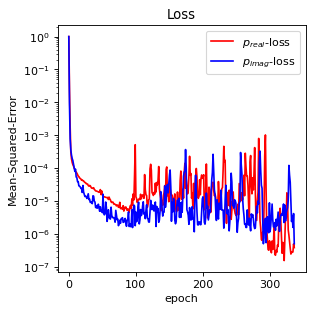

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=80)
loss1 = history.history['p_real_loss']
loss2 = history.history['p_imag_loss']
time_step = np.linspace(0, t, len(history.history["p_real_loss"]))
plt.plot(history.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
plt.plot(history.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Mean-Squared-Error')
plt.title('Loss')
plt.legend()
plt.show()

In [7]:
# predictions
N = 1600
x_max = 8
y_max = 8
x_min = -2
y_min = -2
xx = np.linspace(x_min, x_max, N)
yy = np.linspace(y_min, y_max, N)
sx = 0
sy = 0

x_test, y_test = np.meshgrid(xx, yy)
velmodel = ( ssp_1 + vergrad * ( y_test - sz ) )
k1_test = omega / velmodel 
c_eval = velmodel.flatten()
x_eval = x_test.flatten()
y_eval = y_test.flatten()
r_eval = np.sqrt((x_eval-sx)**2 + (y_eval-sy)**2)

G_real_test = np.real(hankel1(0, k0*r_eval))
G_imag_test = np.imag(hankel1(0, k0*r_eval))

input_plot = [x_eval, y_eval, c_eval, G_real_test, G_imag_test]

pr_pred = p_real.eval(model, input_plot).reshape(x_test.shape)
pi_pred = p_imag.eval(model, input_plot).reshape(x_test.shape)

ps_real_pred = ( pr_pred / np.real( hankel1(0, k0) ) ) ** 2
ps_imag_pred = ( pi_pred / np.real( hankel1(0, k0) ) ) ** 2

tls_pred = -20 * np.log10(np.sqrt( ps_real_pred+ps_imag_pred )).reshape(x_test.shape)
                               
p_real_pred = pr_pred + G_real_test.reshape(x_test.shape)
p_real_pred= p_real_pred
p_imag_pred = pi_pred + G_imag_test.reshape(x_test.shape)
p_imag_pred = p_imag_pred
k1_test = k1_test.reshape(x_test.shape)

# exact solution
p_real_exsol = np.real(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))
p_imag_exsol = np.imag(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))
ps_real_exsol = (p_real_exsol - G_real_test.reshape(x_test.shape)) / np.real(hankel1(0, k0))
ps_imag_exsol = (p_imag_exsol - G_imag_test.reshape(x_test.shape)) / np.imag(hankel1(0, k0))
tls_exsol = -20 * np.log10( np.sqrt( ps_real_exsol**2 + ps_imag_exsol**2 ) )
                               
# pre2tl
pr_exsol = (p_real_exsol / np.real(hankel1(0, k1_test)))
pi_exsol = (p_imag_exsol / np.imag(hankel1(0, k1_test)))
tl_exsol = -20 * np.log10(np.sqrt(pr_exsol ** 2 + pi_exsol ** 2))

pr_pred = (p_real_pred / np.real(hankel1(0, k1_test)))
pi_pred = (p_imag_pred / np.imag(hankel1(0, k1_test)))
tl_pred = -20 * np.log10(np.sqrt(pr_pred ** 2 + pi_pred ** 2))

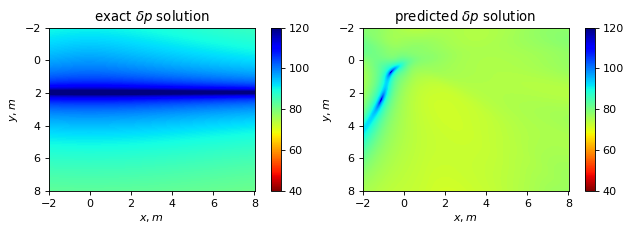

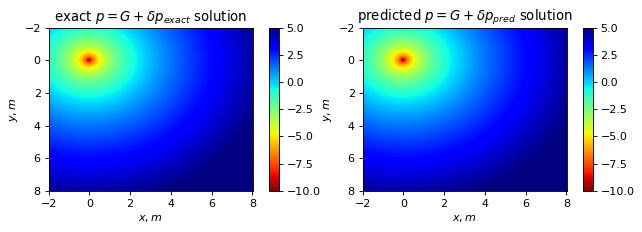

In [8]:
# # pressure
# fig = plt.figure(1, figsize=(8, 6), dpi=80)
# ax = plt.subplot(2, 2, 1)
# ax.invert_yaxis()
# h0 = ax.pcolormesh(xx, yy, p_real_exsol, cmap='jet_r', shading='auto', vmin=0, vmax=1)
# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes("right", size="5%", pad=0.2)
# fig.colorbar(h0, cax=cax1)
# ax.set_xlabel('$x, m$')
# ax.set_ylabel('$y, m$')
# ax.set_title('exact solution')

# ax = plt.subplot(2, 2, 2)
# ax.invert_yaxis()
# h2 = ax.pcolormesh(xx, yy, p_real_pred, cmap='jet_r', shading='auto', vmin=0, vmax=1)
# divider = make_axes_locatable(ax)
# cax3 = divider.append_axes("right", size="5%", pad=0.2)
# fig.colorbar(h2, cax=cax3)
# ax.set_xlabel('$x, m$')
# ax.set_ylabel('$y, m$')
# ax.set_title('predicted solution')
# plt.tight_layout()

# ax = plt.subplot(2, 2, 3)
# ax.invert_yaxis()
# h1 = ax.pcolormesh(xx, yy, p_imag_exsol, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
# divider = make_axes_locatable(ax)
# cax2 = divider.append_axes("right", size="5%", pad=0.2)
# fig.colorbar(h1, cax=cax2)
# ax.set_xlabel('$x, m$')
# ax.set_ylabel('$y, m$')
# ax.set_title('exact solution')

# ax = plt.subplot(2, 2, 4)
# ax.invert_yaxis()
# h3 = ax.pcolormesh(xx, yy, p_imag_pred, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
# divider = make_axes_locatable(ax)
# cax4 = divider.append_axes("right", size="5%", pad=0.2)
# fig.colorbar(h3, cax=cax4)
# ax.set_xlabel('$x, m$')
# ax.set_ylabel('$y, m$')
# ax.set_title('predicted solution')
# plt.tight_layout()
# plt.show()
fig = plt.figure(2, figsize=(8, 3), dpi=80)
ax = plt.subplot(1, 2, 1)
ax.invert_yaxis()
h1 = ax.pcolormesh(xx, yy, tls_exsol, cmap='jet_r', shading='auto', vmin=40, vmax=120)
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h1, cax=cax2)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_title('exact $\delta p$ solution')

ax = plt.subplot(1, 2, 2)
ax.invert_yaxis()
h3 = ax.pcolormesh(xx, yy, tls_pred, cmap='jet_r', shading='auto', vmin=40, vmax=120)
divider = make_axes_locatable(ax)
cax4 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h3, cax=cax4)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_title('predicted $\delta p$ solution')
plt.tight_layout()
plt.show()


fig = plt.figure(3, figsize=(8, 3), dpi=80)
ax = plt.subplot(1, 2, 1)
ax.invert_yaxis()
h1 = ax.pcolormesh(xx, yy, tl_exsol, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h1, cax=cax2)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_title('exact $p=G+\delta p_{exact}$ solution')

ax = plt.subplot(1, 2, 2)
ax.invert_yaxis()
h3 = ax.pcolormesh(xx, yy, tl_pred, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
divider = make_axes_locatable(ax)
cax4 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h3, cax=cax4)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_title('predicted $p=G+\delta p_{pred}$ solution')
plt.tight_layout()
plt.show()

In [9]:
def plot_line(ny, ax):
        zy = ny * dy
        print(ny)
        fig = plt.figure(ax, figsize=(10, 3), dpi=80)
        plt.suptitle('Receive Depth='+str(zy+y_min)+'m')
        ax = plt.subplot(1, 3, 1)
        ax.invert_yaxis()
        h6 = ax.plot(xx, p_real_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h7 = ax.plot(xx, p_real_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$Amp$')
        ax.set_title('Real Pressure')
        plt.legend()

        ax = plt.subplot(1, 3, 2)
        ax.invert_yaxis()
        h8 = ax.plot(xx, p_imag_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h9 = ax.plot(xx, p_imag_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$Amp$')
        ax.set_title('Image Pressure')
        plt.legend()
        plt.tight_layout()

        ax = plt.subplot(1, 3, 3)
        ax.invert_yaxis()
        h10 = ax.plot(xx, tl_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h11 = ax.plot(xx, tl_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$dB$')
        ax.set_title('TL')
        plt.legend()

        plt.tight_layout()
        plt.show()

80


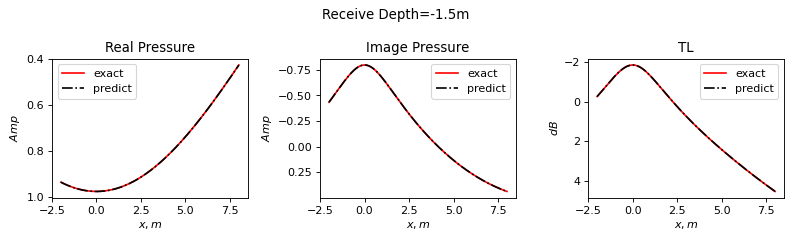

160


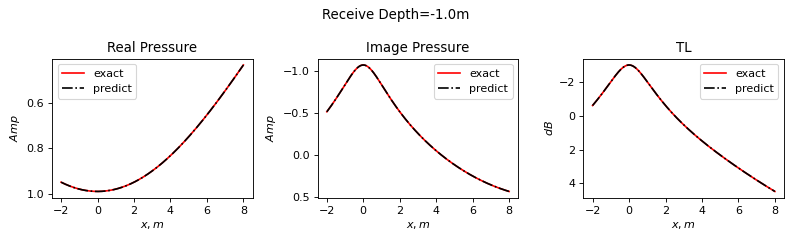

320


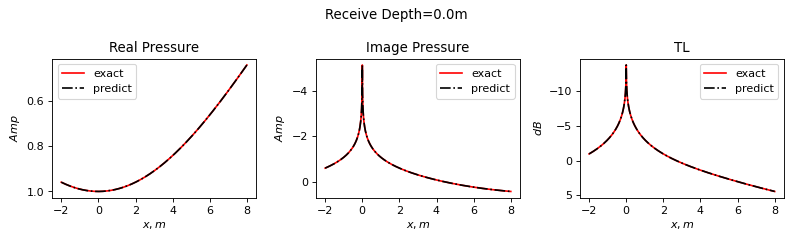

720


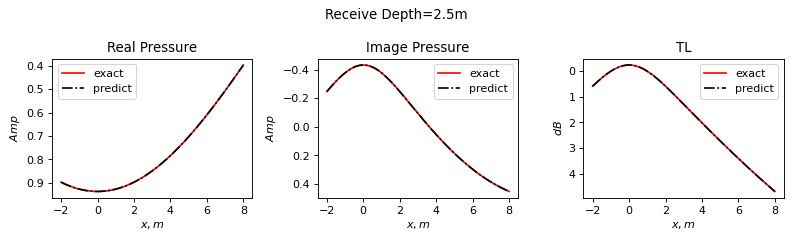

In [10]:
dx = (x_max - x_min) / N
dy = (y_max - y_min) / N
#     zy = 3
#     ny = int(zy / dy)
ax = 5

plot_line(int((-1.5 - y_min)/dy), ax)
plot_line(int((-1 - y_min)/dy), ax)
plot_line(int((+0 - y_min)/dy), ax)
plot_line(int((+2.5 - y_min)/dy), ax)